<img src="../../docs/images/dlsia.png" width=600 />

# Image labeling with Randomized Sparse Mixed Scale Networks

Authors: Eric Roberts and Petrus Zwart

E-mail: PHZwart@lbl.gov, EJRoberts@lbl.gov

___

This notebook highlights some basic functionality with the dlsia package.

In this notebook we will demonstrate an ensemble method for image classification. We define a few randomized sparse mixed scale networks that after some fully connected layers yield a image classifier. We will train a few independent networks that will be combined into a single classifier that yields both a probability and associated standard deviation. 


___




In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.networks import sparsenet
from dlsia.core.networks import baggins
from dlsia.test_data.two_d import random_shapes
from dlsia.core.utils import latent_space_viewer
from dlsia.viz_tools import plots
from dlsia.viz_tools import plot_autoencoder_image_classification as paic


import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import einops
import umap

from IPython.display import Image

Create some data first

In [3]:
N_train = 100
N_labeled = 100

N_test  = 5000
noise_level = 0.15
Nxy = 32

train_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_train,
                                                        noise_level=noise_level,
                                                        n_xy=Nxy)
test_data = random_shapes.build_random_shape_set_numpy(n_imgs=N_test,
                                                       noise_level=noise_level,
                                                       n_xy=Nxy)


This is how it looks

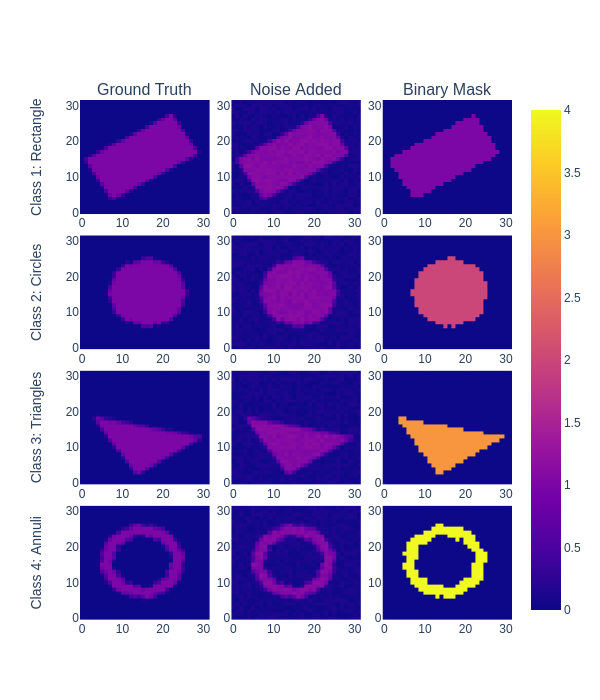

In [4]:
# normally we would use interactive plot here via
# plots.plot_shapes_data_numpy(train_data).show()
# but they don't survive when displayed in github, so
# we make it a static plot instead.
tmp = plots.plot_shapes_data_numpy(train_data)
tmp = tmp.to_image(format="png", scale=1.0)
Image(tmp)

Build data loaders

In [5]:
which_one = "Noisy" 

batch_size = 100

loader_params = {'batch_size': batch_size, 
                 'shuffle': True} 
train_imgs = torch.Tensor(train_data[which_one]).unsqueeze(1)
train_labels = torch.Tensor(train_data["Label"]).unsqueeze(1)-1
train_labels[N_labeled:]=-1 # remove some labels to highlight 'mixed' training

Ttrain_data = TensorDataset(train_imgs,train_labels)
train_loader = DataLoader(Ttrain_data, **loader_params)

loader_params = {'batch_size': batch_size, 
                 'shuffle': False} 
test_images = torch.Tensor(test_data[which_one]).unsqueeze(1)
test_labels = torch.Tensor(test_data["Label"]).unsqueeze(1)-1
Ttest_data = TensorDataset( test_images, test_labels ) 
test_loader = DataLoader(Ttest_data, **loader_params)


Lets build some neural networks

There are a number of parameters to play with that impact the size of the network:

    - latent_shape: the spatial footprint of the image in latent space. 
      I don't recommend going below 4x4, because it interferes with the 
      dilation choices. This is a bit of a annoyiong feature, we need to fix that. 
      Its on the list.
    - out_channels: the number of channels of the latent image. Determines the
      dimension of latent space: (channels,latent_shape[-2], latent_shape[-1])
    - depth: the depth of the random sparse convolutional encoder.
    - hidden channels: The number of channels put out per convolution. 
    - max_degree / min_degree : This determines how many connections you have per node.
    
    
Other parameters do not impact the size of the network dramatically / at all:

    - in_shape: determined by the input shape of the image.
    - dilations: the maximum dilation should not exceed the smallest image dimension.
    - alpha_range: determines the type of graphs (wide vs skinny). When alpha is large,
                   the chances for skinny graphs to be generated increases. 
                   We don't know which parameter choice is best, so we randomize it's choice.
    - gamma_range: no effect unless the maximum degree and min_degree are far apart.
                   We don't know which parameter choice is best, so we randomize it's choice.
    - pIL,pLO,IO: keep as is. 
    - stride_base: make sure your latent image size can be generated from the in_shape 
                   by repeated division of with this number.

For the classification, specify the number of output classes. Here we work with 4 shapes, so set it to 4.
The dropout rate governs the dropout layers in the classifier part of the networks and doesn't affect the encoder part.

We generate an ensemble of models

In [33]:
networks = []
Nmodels = 31
for ii in range(Nmodels):
    rando = sparsenet.SparseLabeler(in_shape=(32, 32), 
                                          latent_shape=(8, 8), 
                                          out_classes=4,
                                          depth=10, 
                                          dilations=[1,2,3,4], 
                                          hidden_channels=3,
                                          in_channels=1,
                                          out_channels=1, 
                                          alpha_range=(0.05, 0.25), 
                                          gamma_range=(0.0, 0.5), 
                                          max_degree=4, min_degree=2, 
                                          pIL=0.15, 
                                          pLO=0.15, 
                                          IO=False, 
                                          stride_base=2, 
                                          dropout_rate=0.15)
    networks.append(rando)
    pytorch_total_params = helpers.count_parameters(rando)
    print( "Number of parameters:", pytorch_total_params)

Number of parameters: 6090
Number of parameters: 6063
Number of parameters: 6348
Number of parameters: 5637
Number of parameters: 6720
Number of parameters: 6873
Number of parameters: 5922
Number of parameters: 6014
Number of parameters: 7091
Number of parameters: 6252
Number of parameters: 5626
Number of parameters: 6074
Number of parameters: 6912
Number of parameters: 6442
Number of parameters: 6162
Number of parameters: 7885
Number of parameters: 6246
Number of parameters: 6259
Number of parameters: 7085
Number of parameters: 6222
Number of parameters: 6714
Number of parameters: 6759
Number of parameters: 6780
Number of parameters: 6225
Number of parameters: 6393
Number of parameters: 7460
Number of parameters: 7056
Number of parameters: 5875
Number of parameters: 6405
Number of parameters: 6706
Number of parameters: 7487


Train all models

In [35]:
F1_scores = []
for ii in range(Nmodels):
    print()
    print("Model %i"%(ii+1))
    rando = networks[ii]
    torch.cuda.empty_cache()
    learning_rate = 1e-3
    num_epochs=25

    criterion_label = nn.CrossEntropyLoss() 
    optimizer_label = optim.Adam(rando.parameters(), lr=learning_rate)

    rv = train_scripts.train_labeling(net=rando.to('cuda:0'),
                                                        trainloader=train_loader,
                                                        validationloader=test_loader, 
                                                        NUM_EPOCHS=num_epochs,
                                                        criterion=criterion_label,
                                                        optimizer=optimizer_label,
                                                        device="cuda:0", 
                                                        show=25, 
                                                        clip_value=100.0)    
    F1_scores.append(rv[1]['F1 validation macro'][rv[1]['Best model index']])



Model 1
Epoch 25 of 25 | Learning rate 1.000e-03
   Training Loss: 6.7869e-01 | Validation Loss: 7.8638e-01
   Micro Training F1: 0.6900 | Micro Validation F1: 0.6732
   Macro Training F1: 0.7081 | Macro Validation F1: 0.6760

Model 2
Epoch 25 of 25 | Learning rate 1.000e-03
   Training Loss: 6.5213e-01 | Validation Loss: 9.7091e-01
   Micro Training F1: 0.8000 | Micro Validation F1: 0.5860
   Macro Training F1: 0.7974 | Macro Validation F1: 0.5856

Model 3
Epoch 25 of 25 | Learning rate 1.000e-03
   Training Loss: 7.0635e-01 | Validation Loss: 8.7518e-01
   Micro Training F1: 0.7400 | Micro Validation F1: 0.6322
   Macro Training F1: 0.7562 | Macro Validation F1: 0.6360

Model 4
Epoch 25 of 25 | Learning rate 1.000e-03
   Training Loss: 6.7337e-01 | Validation Loss: 8.9285e-01
   Micro Training F1: 0.7900 | Micro Validation F1: 0.6292
   Macro Training F1: 0.7952 | Macro Validation F1: 0.6339

Model 5
Epoch 25 of 25 | Learning rate 1.000e-03
   Training Loss: 6.7371e-01 | Validation 

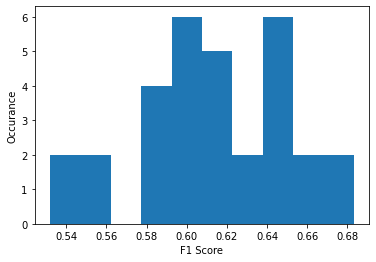

In [41]:
plt.hist(F1_scores, bins=10)
plt.xlabel("F1 Score")
plt.ylabel("Occurance")
plt.show()

While the individual models have a performance that is far from ideal, an ensemble model behaves a lot better. Here we do simple averaging of predictions. The histogram, above shows that we have a mean value of F1 on test data of about 63%. When we build an ensemble method, the F1 score increases to 92% or better.

In [42]:
bagged_model = baggins.model_baggin(networks)

Lets go over the full validation dataset and see what we get

In [43]:
mean = []
std = []
true_lbl = []
inp_img = []
inferred_label = []
for batch in test_loader:
    true_lbl.append(batch[1])
    with torch.no_grad():
        inp_img.append(batch[0].cpu())
        mp,sp = bagged_model(batch[0], "cuda:0", True)
        mean.append(mp.cpu())
        std.append(sp.cpu())
        guessed = torch.argmax(mp, axis=-1)
        inferred_label.append(guessed)
mean = torch.cat(mean, dim=0)
std = torch.cat(std, dim=0)
true_lbl = torch.cat(true_lbl, dim=0)    
inp_img = torch.cat(inp_img, dim=0)
inferred_label = torch.cat(inferred_label, dim=0).unsqueeze(-1)

We compute F1 metrics and visualize the results

Macro F1 on Test Data  0.93580
Micro F1 on Test Data  0.93587

--------       The first 5 images encountered     ----------


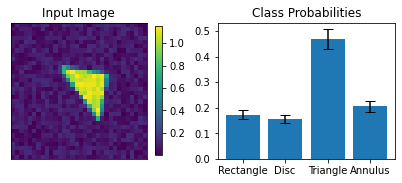

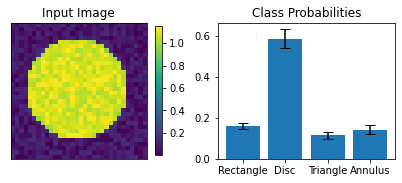

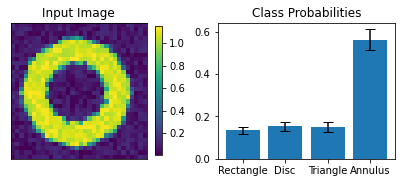

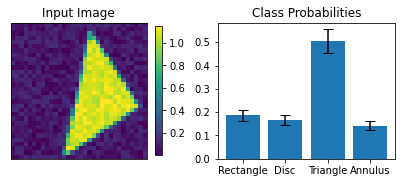

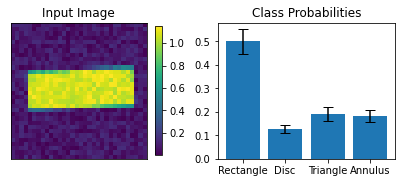

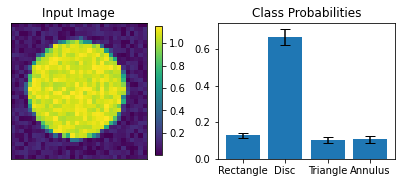


--------       Incorrectly classified images (15 maximum)  ----------


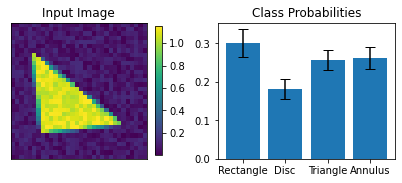

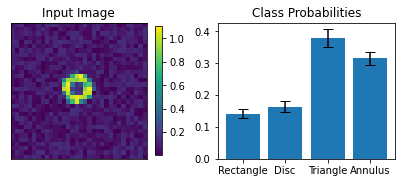

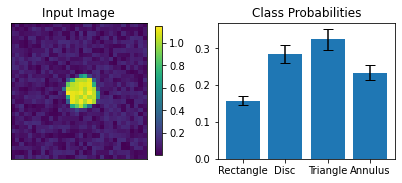

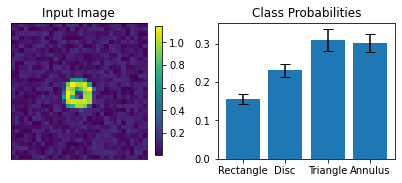

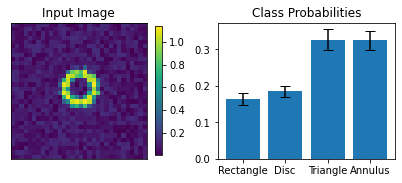

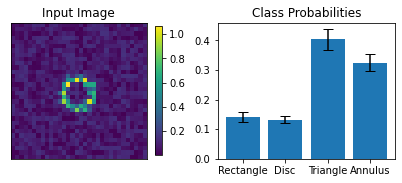

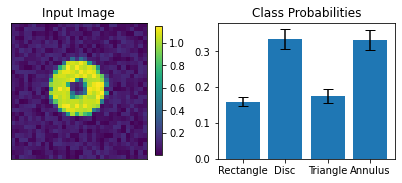

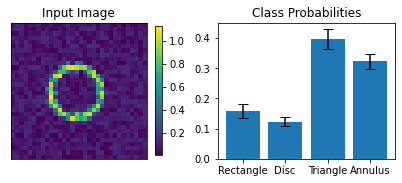

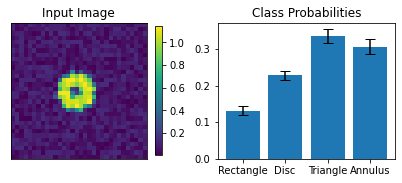

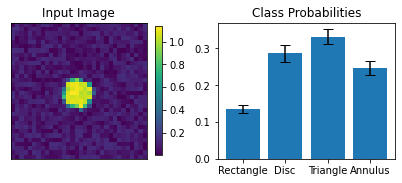

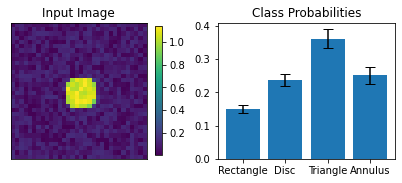

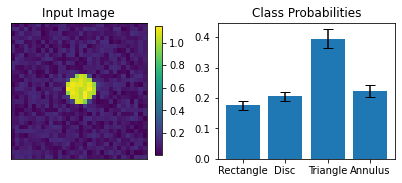

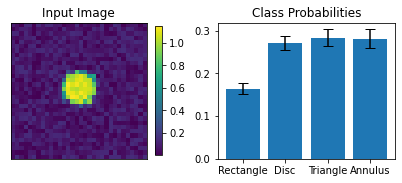

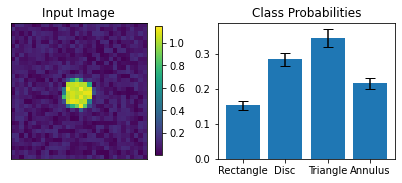

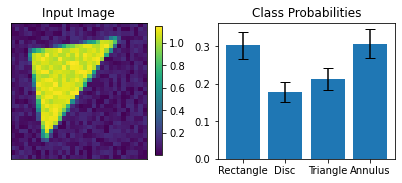

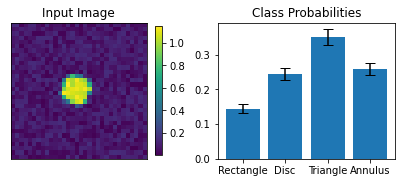

In [46]:
count=0
tmp = train_scripts.segmentation_metrics(mean, 
                                         true_lbl.flatten().type(torch.LongTensor), 
                                         missing_label=-1) 
print(f"Macro F1 on Test Data {tmp[0]: 6.5f}")
print(f"Micro F1 on Test Data {tmp[1]: 6.5f}")
print()
assert tmp[1] > 0.75 # just to make sure all is ok

print("--------       The first 5 images encountered     ----------")
for mp,sp,tlbl,ilbl,img in zip(mean, std, true_lbl.flatten(), inferred_label.flatten(), inp_img):    
    fig = paic.plot_image_and_class_probabilities(input_img=img[0].numpy(), 
                                       class_names= ["Rectangle","Disc","Triangle","Annulus"],
                                       p_classification=mp.numpy(), 
                                       std_p_classification=sp.numpy())
    plt.show()
    count += 1
    if count > 5:
        break
print()        
print("--------       Incorrectly classified images (15 maximum)  ----------")
count=0
for mp,sp,tlbl,ilbl,img in zip(mean, std, true_lbl.flatten(), inferred_label.flatten(), inp_img):
    if int(tlbl) != int(ilbl):    
        fig = paic.plot_image_and_class_probabilities(input_img=img[0].numpy(), 
                                           class_names= ["Rectangle","Disc","Triangle","Annulus"],
                                           p_classification=mp.numpy(), 
                                           std_p_classification=sp.numpy())
        count += 1
        if count > 15:
            break


    

It would be nice to save these networks of course. The issue is that the networks are generated using a random numnber generator, and have no predetermined topology. Because of this feature, some utility functions have been developed.

Saving a random network is done via its "save_network_parameters" function. If a file name is supplied, a small file will be saved, if the filename is not supplied, an OrderedDict will be returned. A saved network parameter file can be used to instantiate that same network via the SparseLabeler_from_file method.



In [47]:
new_networks = []
for ii in range(Nmodels):
    name = "model_%i.pt"%ii
    networks[ii].save_network_parameters(name)
    new_networks.append(sparsenet.SparseLabeler_from_file(name))
    